In [17]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import scipy as sc
import properscoring as ps
from losses import EnergyScore, KernelScore

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
# Parameters of training
learning_rate = 0.001
epsilon = 1e-8

num_iter = 6000
batch_size = 256

test_ratio = 0.1
num_networks = 5

num_print = 1000
test_size = 10

# Making Toy Data
Toy dataset is y = 10sin(x) + epsilon

If x < 0:  = N(0, sigma1^2) -> In this example sigma1 = 3 <br>
If x > 0:  = N(0, sigma2^2) -> In this example sigma2 = 1

Train data shape: (3600, 1)
Test data shape: (401, 1)


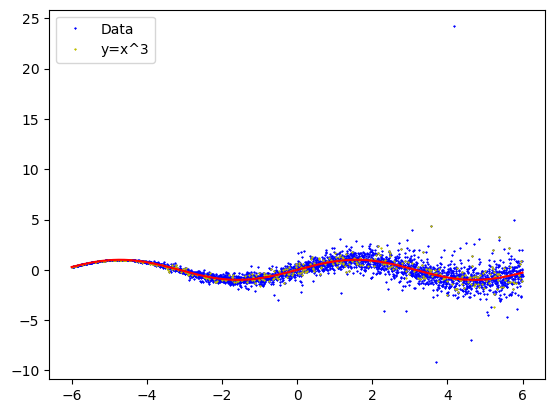

In [20]:
data_range = 6
data_step = 0.003

var_increase = 500

data_sigma1 = 0.1
data_sigma2 = 0.5
num_data = 1

data_x = np.arange(-data_range, data_range + data_step, data_step)
data_x = np.reshape(data_x, [data_x.shape[0], 1])

data_y_true = np.sin(data_x)

var_factor = np.zeros(data_x.shape)
var_len = data_x.shape[0] - var_increase
var_factor[var_increase:,0] = (var_factor[var_increase:,0]+1)* np.linspace(0,2,var_len)
data_y = data_y_true + var_factor*sc.stats.t.rvs(4, loc = 0, scale = 0.4, size = data_x.shape)
#data_y = data_y_true + var_factor*np.random.normal(0, 0.5, data_x.shape) 



#data_x, data_y = shuffle(data_x, data_y)
        
num_train_data = int(data_x.shape[0] * (1 - test_ratio))
num_test_data  = data_x.shape[0] - num_train_data
test_ind = np.random.choice(data_x.shape[0], num_test_data, replace=False)
train_ind = np.random.choice(data_x.shape[0], num_train_data ,replace = False)

train_x = data_x[train_ind, :]
train_y = data_y[train_ind, :]
test_x  = data_x[test_ind, :]
test_y  = data_y[test_ind, :]

print("Train data shape: " + str(train_x.shape))
print("Test data shape: " + str(test_x.shape))

plt.plot(train_x, train_y, 'b*', markersize=1)
plt.plot(test_x, test_y, 'y*', markersize=1)
plt.plot(data_x, data_y_true, 'r')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [21]:
# Make batch data 
def make_batch(data_size, sample_size, data_x, data_y):
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, num_data])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i], :]
        batch_y[i,:] = data_y[batch_idx[i], :] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y   

def to_np(x):
    return x.cpu().detach().numpy()

# New network

In [22]:
class model_reparam(torch.nn.Module):
    def __init__(self, n_samples = 500):
        super(model_reparam, self).__init__()
        self.n_samples = n_samples
        self.fc1 = torch.nn.Linear(1, 16)
        self.fc2 = torch.nn.Linear(16, 32)
        self.mu = torch.nn.Linear(32, 1)
        self.sigma = torch.nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        sigma = torch.nn.functional.softplus(self.sigma(x))
        noise_shape = list(mu.shape)
        noise_shape.append(self.n_samples)
        noise = torch.randn(noise_shape).to(x.device)
        out = torch.unsqueeze(mu,-1) + torch.unsqueeze(sigma,1) * noise
        
        return out

In [23]:
sample_model = model_reparam(n_samples = 50).to(device)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
# Loss function
energy_score = EnergyScore(d = 1)

In [30]:
train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]

loss_train = 0
loss_test = 0

for iter in range(num_iter):
    # Make batches(testing)
    batch_x_test, batch_y_test = make_batch(test_data_num, test_size, test_x, test_y)

    # Make batches(training)
    batch_x, batch_y = make_batch(train_data_num, batch_size, train_x, train_y)
    out = sample_model(batch_x)
    
    loss = energy_score(out, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train += loss.item()

    # Test
    out_test = sample_model(batch_x_test)
    loss = energy_score(out_test, batch_y_test)
    loss_test += loss.item()

    
    if iter % num_print == 0 and iter != 0:
        print(('-------------------------') + ' Iteration: ' + str(iter) + ' -------------------------')
        print('Average Train Loss: ' + str(loss_train / num_print))
        print('Average Test Loss: ' + str(loss_test / num_print))
        print('\n')
        
        loss_train = 0
        loss_test = 0

------------------------- Iteration: 1000 -------------------------
Average Train Loss: 0.28565515038371087
Average Test Loss: 0.2761920450553298


------------------------- Iteration: 2000 -------------------------
Average Train Loss: 0.27025730347633364
Average Test Loss: 0.26001560179889205


------------------------- Iteration: 3000 -------------------------
Average Train Loss: 0.27024073883891103
Average Test Loss: 0.2675079294964671


------------------------- Iteration: 4000 -------------------------
Average Train Loss: 0.26876825596392157
Average Test Loss: 0.25894070336222647


------------------------- Iteration: 5000 -------------------------
Average Train Loss: 0.27023692083358763
Average Test Loss: 0.2586808219216764




In [31]:
# Predict more samples
sample_model.n_samples = 5000

# Get Unknown dataset and test 
x_sample = np.arange(-10, 10 + 0.1, 0.1)
x_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

y_sample = np.sin(x_sample)

x_sample_tensor = torch.FloatTensor(x_sample).to(device)
y_sample_tensor = torch.FloatTensor(y_sample).to(device)

# Output
out = sample_model(x_sample_tensor).detach().numpy()

mean_pred = np.mean(out,axis = -1)
q_975 = np.quantile(out, 0.975, axis = -1)
q_025 = np.quantile(out, 0.025, axis = -1)
q_75 = np.quantile(out, 0.75, axis = -1)
q_25 = np.quantile(out, 0.25, axis = -1)

#Print error
mse = np.mean(np.square(out - y_sample))
crps = np.mean(ps.crps_ensemble(y_sample, out))
res_new = f"MSE : {mse}, CRPS : {crps}"

print(f"Ensemble model: {res_new}")

Ensemble model: MSE : 1.4786752453505991, CRPS : 0.30208561762812175


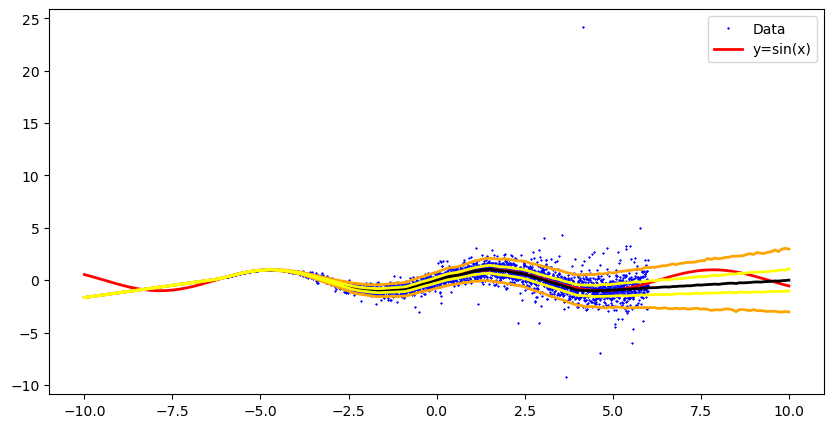

In [32]:
fig, axs = plt.subplots(figsize = (10,5))

axs.plot(data_x, data_y, 'b*', markersize=1, label='Data')
axs.plot(x_sample, y_sample, 'r', linewidth = 2, label='y=sin(x)')
axs.plot(x_sample, mean_pred, linewidth = 2, color = "black")
axs.plot(x_sample, q_975, linewidth = 2, color = "orange")
axs.plot(x_sample, q_025, linewidth = 2, color = "orange")
axs.plot(x_sample, q_75, linewidth = 2, color = "yellow")
axs.plot(x_sample, q_25, linewidth = 2, color = "yellow")

axs.legend()